Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### **Importing Skin Cancer Data**

### **Importing all the important libraries**

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
import glob
import PIL  
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras.regularizers import l2

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!unzip  '/content/drive/My Drive/CNN_assignment.zip' -d '/content/'
os.rename('/content/Skin cancer ISIC The International Skin Imaging Collaboration','/content/datasets')

Mounted at /content/drive
Archive:  /content/drive/My Drive/CNN_assignment.zip
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: /content/Skin cancer ISIC 

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/datasets/Train")
data_dir_test = pathlib.Path('/content/dataset/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
0


### **Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### **Create a dataset**

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Writing train dataset
## Using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    batch_size=batch_size,
    image_size=(img_width,img_height),
    validation_split=0.2,
    subset='training'   
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Writing validation dataset here
## Using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    batch_size=batch_size,
    image_size=(img_width,img_height),
    validation_split=0.2,
    subset='validation'   
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### **Visualize the data**
#### Visualizing one instance of all the nine classes present in the dataset

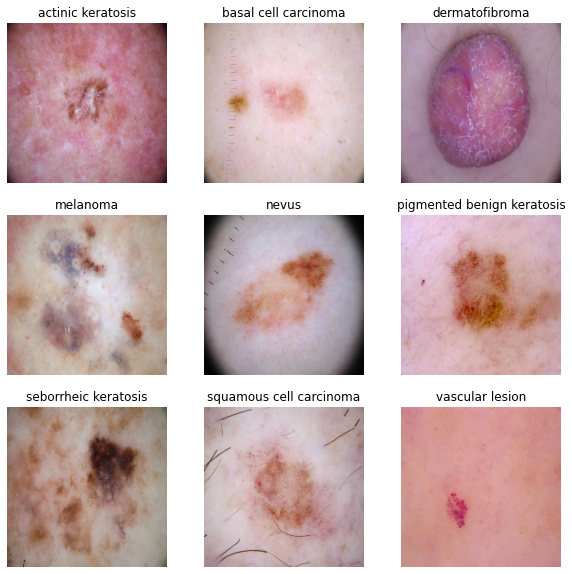

In [10]:
import matplotlib.pyplot as plt

classes_length = len(class_names)
# images = list(train_ds.map(lambda x, y: x))
# labels = list(train_ds.map(lambda x, y: y))
plt.figure(figsize=(10,10))
for k in range(classes_length):
  temp_ds = train_ds.filter(lambda img, lbl: tf.math.equal(lbl[0], k))
  for img, lbl in temp_ds.take(1):
    ax = plt.subplot(3, 3, k+1)
    plt.imshow(img[0].numpy().astype('uint8'))
    plt.title(class_names[lbl[0]])
    plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)
`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Create the model**
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
# normalization_layer = layers.Rescaling(1./255)
# train_normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(train_normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))
# val_normalized_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(val_normalized_ds))

In [13]:
### Model 1
model = Sequential()

model.add(Rescaling(1./255, input_shape=(img_height,img_width,3)))
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_height,img_width,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_height,img_width,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', input_shape=(img_height,img_width,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(classes_length))
model.add(Activation('softmax'))


### **Compile the model**
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 90, 90, 32)        0         
                                                        

### **Train the model**

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 24s 87ms/step - loss: 2.0564 - accuracy: 0.1892 - val_loss: 2.0353 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 2s 32ms/step - loss: 2.0213 - accuracy: 0.1942 - val_loss: 2.0410 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 2s 32ms/step - loss: 2.0283 - accuracy: 0.1897 - val_loss: 2.0432 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 2s 32ms/step - loss: 1.9709 - accuracy: 0.2517 - val_loss: 2.0528 - val_accuracy: 0.1723
Epoch 5/20
56/56 [==============================] - 2s 31ms/step - loss: 1.8845 - accuracy: 0.2746 - val_loss: 1.7308 - val_accuracy: 0.3982
Epoch 6/20
56/56 [==============================] - 2s 32ms/step - loss: 1.7456 - accuracy: 0.3544 - val_loss: 1.6588 - val_accuracy: 0.4385
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 1.6308 - accuracy: 0.4018 - val_loss: 1.5921 - val_accuracy: 0.4340
Epoch 8/20
5

### **Visualizing training results**

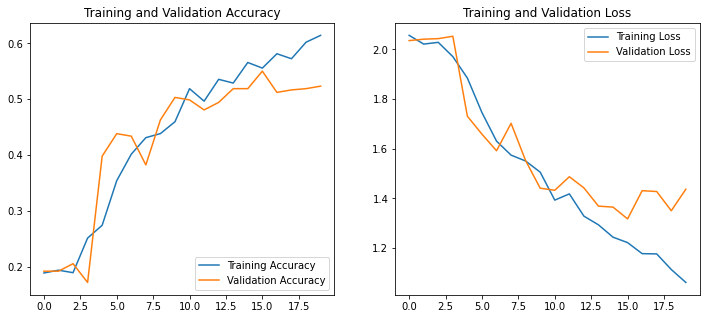

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


#### **Findings**

* The training dataset marks 62% accurancy and where as validation dataset at 52%
* Same with loss training data marks lower than the validation dataset

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 


### **Create the model, compile and train the model**

In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
# Model 2 - Dropout layer
model = Sequential()

model.add(Rescaling(1./255, input_shape=(img_height,img_width,3)))
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_height,img_width,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_height,img_width,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', input_shape=(img_height,img_width,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,kernel_regularizer=l2(0.5)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes_length))
model.add(Activation('softmax')) 

### **Compiling the model**



In [19]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### **Training the model**

In [20]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 37ms/step - loss: 47.8616 - accuracy: 0.1847 - val_loss: 14.4244 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 2s 33ms/step - loss: 6.5805 - accuracy: 0.2087 - val_loss: 2.8764 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 2s 33ms/step - loss: 2.2922 - accuracy: 0.1981 - val_loss: 2.0325 - val_accuracy: 0.2148
Epoch 4/20
56/56 [==============================] - 2s 33ms/step - loss: 2.0229 - accuracy: 0.2472 - val_loss: 1.9238 - val_accuracy: 0.3065
Epoch 5/20
56/56 [==============================] - 2s 32ms/step - loss: 1.9182 - accuracy: 0.2835 - val_loss: 1.9260 - val_accuracy: 0.2841
Epoch 6/20
56/56 [==============================] - 2s 33ms/step - loss: 1.8790 - accuracy: 0.3075 - val_loss: 1.8518 - val_accuracy: 0.3221
Epoch 7/20
56/56 [==============================] - 2s 33ms/step - loss: 1.8278 - accuracy: 0.3086 - val_loss: 2.0524 - val_accuracy: 0.2796
Epoch 8/20


### **Visualizing the results**

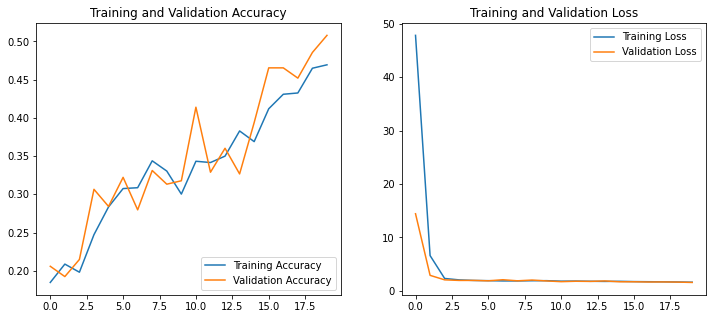

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Findings**

* The training dataset marks 46% accurancy and where as validation dataset at 50%
* The training and validation datasets marks same loss
* Dropout layer did not improve the model performance

#### **Finding the distribution of classes in the training dataset.**
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

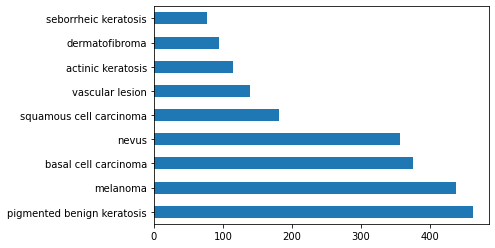

In [22]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list=[ os.path.basename(os.path.dirname(x)) for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
# print (path_list)
# print (cancertype_list)
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df['Label'].value_counts().plot(kind='barh')

#### **Findings** 
#### - seborrheic keratosis has least number of samples
#### - pigmented benign keratosis has highest number of samples.


#### **Rectifying the class imbalance**
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [23]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [24]:
path_to_training_dataset="/content/datasets/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/datasets/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F931648CB10>: 100%|██████████| 500/500 [00:19<00:00, 25.97 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/datasets/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F93164D77D0>: 100%|██████████| 500/500 [00:22<00:00, 22.37 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/datasets/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F93704D6AD0>: 100%|██████████| 500/500 [00:20<00:00, 24.21 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/datasets/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x7F93165A74D0>: 100%|██████████| 500/500 [01:27<00:00,  5.69 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/datasets/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7F9316156FD0>: 100%|██████████| 500/500 [01:31<00:00,  5.48 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/datasets/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F93160FFD50>: 100%|██████████| 500/500 [00:18<00:00, 26.35 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/datasets/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F93704C3850>: 100%|██████████| 500/500 [00:43<00:00, 11.48 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/datasets/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9316599550>: 100%|██████████| 500/500 [00:16<00:00, 29.89 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/datasets/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F93161FBC50>: 100%|██████████| 500/500 [00:16<00:00, 29.60 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [25]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [41]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

[]

In [42]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

[]

In [43]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [44]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [45]:
new_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Training the model on the data created using Augmentor**

In [46]:
batch_size = 32
img_height = 180
img_width = 180

In [47]:
train_new_path = '/content/datasets/Train_new'
if not os.path.exists(train_new_path):
  os.makedirs(train_new_path)


In [48]:
# Move output files to new folder "Train_new"
for new_path in path_list_new:
  new_dir = os.path.dirname(os.path.dirname(new_path)).replace('Train','Train_new')
  if not os.path.exists(new_dir):
    os.makedirs(new_dir)
  new_file = os.path.basename(new_path)
  shutil.move(new_path,new_dir+'/'+new_file)

#### **Creating a training dataset**

In [49]:
data_dir_train="/content/datasets/Train_new"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Creating a validation dataset**

In [50]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### **Creating the model** (make sure to include normalization)

In [51]:
# Model 3 - After Augmentation
model = Sequential()

model.add(Rescaling(1./255, input_shape=(img_height,img_width,3)))
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_height,img_width,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_height,img_width,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', input_shape=(img_height,img_width,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128,kernel_regularizer=l2(0.5)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes_length))
model.add(Activation('softmax')) 


#### **Compiling the model** (Choose optimizer and loss function appropriately)

In [52]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Training the model**

In [56]:
epochs = 80
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/80
113/113 [==============================] - 13s 104ms/step - loss: 0.7891 - accuracy: 0.7494 - val_loss: 0.9527 - val_accuracy: 0.6833
Epoch 2/80
113/113 [==============================] - 13s 106ms/step - loss: 0.8833 - accuracy: 0.7211 - val_loss: 0.9277 - val_accuracy: 0.7222
Epoch 3/80
113/113 [==============================] - 13s 106ms/step - loss: 0.8643 - accuracy: 0.7258 - val_loss: 1.1308 - val_accuracy: 0.6322
Epoch 4/80
113/113 [==============================] - 13s 105ms/step - loss: 0.7730 - accuracy: 0.7619 - val_loss: 0.8211 - val_accuracy: 0.7678
Epoch 5/80
113/113 [==============================] - 13s 105ms/step - loss: 0.7260 - accuracy: 0.7847 - val_loss: 0.8910 - val_accuracy: 0.7322
Epoch 6/80
113/113 [==============================] - 13s 106ms/step - loss: 0.7453 - accuracy: 0.7731 - val_loss: 0.9179 - val_accuracy: 0.7233
Epoch 7/80
113/113 [==============================] - 13s 106ms/step - loss: 0.7611 - accuracy: 0.7769 - val_loss: 0.8910 - val_ac

#### **Visualizing the model results**

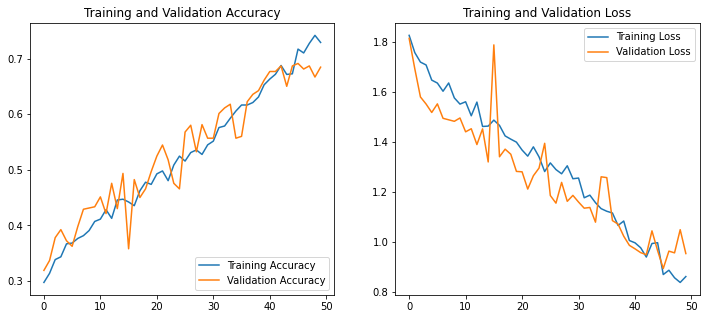

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Findings** 
#### - Tunning epochs model is improved
#### - Accuracy increased from 46% to 93% after augmentation 
#### - This is our final model 
